# dynamic envs & planning
- Sara Echeverría 
- Ricardo Méndez   
- Melissa Pérez 

Repositorio: https://github.com/bl33h/dynamicEnvs

## Task1
### 1. ¿Qué es Prioritized Sweeping para ambientes determinísticos?
Es un método de planificación que organiza los estados según la magnitud del cambio esperado en sus valores. En entornos determinísticos, cada acción lleva a un único resultado, lo que permite actualizar primero los estados más influyentes y propagar sus efectos con mayor eficiencia.

### 2. ¿Qué es Trajectory Sampling?
Es una técnica que genera trayectorias completas a partir del estado actual siguiendo una política, acumulando recompensas y actualizando valores en los estados recorridos. Se enfoca en rutas específicas en lugar de todo el espacio de estados, reduciendo el costo computacional.

### 3. ¿Qué es Upper Confidence Bounds para Árboles (UCT)?
Es una regla de selección usada en Monte Carlo Tree Search. Combina la recompensa media de cada acción con un término de confianza que incentiva probar acciones menos visitadas. De esta forma, equilibra exploración y explotación para identificar de manera más eficiente las ramas prometedoras del árbol.

## Task 2

In [1]:
import math
import random
from collections import defaultdict, deque
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

def make_env():
    env = gym.make("FrozenLake-v1", is_slippery=True, map_name="4x4")
    env.reset(seed=SEED)
    return env

def moving_average(x, w=50):
    if len(x) == 0: 
        return x
    w = max(1, min(w, len(x)))
    return np.convolve(x, np.ones(w)/w, mode="same")

In [3]:
# MCTS con UCT para FrozenLake-v1

class MCTSNode:
    __slots__ = ("N", "W", "children_actions")
    def __init__(self, n_actions):
        self.N = 0
        self.W = 0.0
        self.children_actions = {a: {"N": 0, "W": 0.0} for a in range(n_actions)}

class MCTSAgent:
    def __init__(self, n_states, n_actions, P, gamma=0.99, c=math.sqrt(2), rollout_depth=30, sims_per_decision=200):
        """
        P: estructura de transiciones de FrozenLake: P[s][a] = [(prob, s', r, done), ...]
        """
        self.n_states = n_states
        self.n_actions = n_actions
        self.P = P
        self.gamma = gamma
        self.c = c
        self.rollout_depth = rollout_depth
        self.sims_per_decision = sims_per_decision
        self.tree = {}

    def _node(self, s):
        if s not in self.tree:
            self.tree[s] = MCTSNode(self.n_actions)
        return self.tree[s]

    def _uct(self, s_node, a):
        a_stats = s_node.children_actions[a]
        Na = a_stats["N"]
        if Na == 0:
            return float("inf")
        Q = a_stats["W"] / Na
        return Q + self.c * math.sqrt(math.log(s_node.N + 1) / Na)

    def _sample_transition(self, s, a):
        probs = self.P[s][a]
        r = np.random.rand()
        cum = 0.0
        for p, s2, rew, done in probs:
            cum += p
            if r <= cum:
                return s2, rew, done
        p, s2, rew, done = probs[-1]
        return s2, rew, done

    def _rollout(self, s):
        G = 0.0
        discount = 1.0
        for _ in range(self.rollout_depth):
            a = np.random.randint(self.n_actions)
            s, r, done = self._sample_transition(s, a)
            G += discount * r
            discount *= self.gamma
            if done:
                break
        return G

    def _simulate(self, s0):
        path = []
        s = s0
        G = 0.0
        discount = 1.0

        for depth in range(self.rollout_depth):
            node = self._node(s)
            ucts = [self._uct(node, a) for a in range(self.n_actions)]
            a = int(np.argmax(ucts))
            path.append((s, a))
            s_next, r, done = self._sample_transition(s, a)
            G += discount * r
            discount *= self.gamma
            s = s_next
            if done:
                break

        if not self._is_terminal(s):
            G += discount * self._rollout(s)

        for (s_i, a_i) in path:
            node = self._node(s_i)
            node.N += 1
            node.W += G
            a_stats = node.children_actions[a_i]
            a_stats["N"] += 1
            a_stats["W"] += G

    def _is_terminal(self, s):
        for a in range(self.n_actions):
            trans = self.P[s][a]
            all_done = all(done for _, _, _, done in trans)
            if not all_done:
                return False
        return True

    def select_action(self, s):
        for _ in range(self.sims_per_decision):
            self._simulate(s)

        node = self._node(s)
        values = []
        for a in range(self.n_actions):
            stats = node.children_actions[a]
            if stats["N"] == 0:
                values.append(-1e9)
            else:
                values.append(stats["W"] / stats["N"])
        return int(np.argmax(values))


In [ ]:
# Dyna-Q+

class DynaQPlusAgent:
    def __init__(self, n_states, n_actions, alpha=0.1, gamma=0.99, epsilon=0.1,
                 planning_steps=50, bonus_k=1e-3):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.planning_steps = planning_steps
        self.bonus_k = bonus_k

        self.Q = np.zeros((n_states, n_actions), dtype=np.float32)
        self.model = defaultdict(list)
        self.last_visit = defaultdict(lambda: 0)
        self.timestep = 0

        self.visited_pairs = set()

    def policy(self, s):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        return int(np.argmax(self.Q[s]))

    def update_real(self, s, a, r, s2, done):
        target = r + (0.0 if done else self.gamma * np.max(self.Q[s2]))
        self.Q[s, a] += self.alpha * (target - self.Q[s, a])

        self.model[(s, a)].append((s2, r, done))
        self.visited_pairs.add((s, a))

        self.timestep += 1
        self.last_visit[(s, a)] = self.timestep

    def plan(self):
        if not self.model:
            return
        keys = list(self.model.keys())
        for _ in range(self.planning_steps):
            s, a = keys[np.random.randint(len(keys))]
            samples = self.model[(s, a)]
            s2, r, done = samples[np.random.randint(len(samples))]
            tau = self.last_visit[(s, a)]
            bonus = self.bonus_k * math.sqrt(max(1, self.timestep - tau))
            r_prime = r + bonus
            target = r_prime + (0.0 if done else self.gamma * np.max(self.Q[s2]))
            self.Q[s, a] += self.alpha * (target - self.Q[s, a])


In [ ]:
def run_mcts(env, episodes=500, max_steps=200, sims_per_decision=200, c=math.sqrt(2)):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    P = env.unwrapped.P
    agent = MCTSAgent(n_states, n_actions, P, c=c, sims_per_decision=sims_per_decision)

    rewards, successes, steps_to_goal = [], [], []
    for ep in range(episodes):
        s, _ = env.reset(seed=SEED + ep)
        ep_reward = 0.0
        for t in range(max_steps):
            a = agent.select_action(s)
            s2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            ep_reward += r
            s = s2
            if done:
                break
        rewards.append(ep_reward)
        success = 1 if ep_reward > 0 else 0
        successes.append(success)
        steps_to_goal.append(t + 1 if success else max_steps)
    return {
        "rewards": np.array(rewards),
        "successes": np.array(successes),
        "steps": np.array(steps_to_goal),
    }

In [6]:
def run_dyna_q_plus(env, episodes=500, max_steps=200, alpha=0.1, gamma=0.99, epsilon=0.1,
                    planning_steps=50, bonus_k=1e-3):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    agent = DynaQPlusAgent(n_states, n_actions, alpha, gamma, epsilon, planning_steps, bonus_k)

    rewards, successes, steps_to_goal = [], [], []
    visited_frac = []

    total_pairs = n_states * n_actions

    for ep in range(episodes):
        s, _ = env.reset(seed=SEED + 1000 + ep)
        ep_reward = 0.0
        for t in range(max_steps):
            a = agent.policy(s)
            s2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            agent.update_real(s, a, r, s2, done)
            agent.plan()
            s = s2
            ep_reward += r
            if done:
                break

        rewards.append(ep_reward)
        success = 1 if ep_reward > 0 else 0
        successes.append(success)
        steps_to_goal.append(t + 1 if success else max_steps)
        visited_frac.append(len(agent.visited_pairs) / total_pairs)

    return {
        "rewards": np.array(rewards),
        "successes": np.array(successes),
        "steps": np.array(steps_to_goal),
        "visited_frac": np.array(visited_frac),
    }


In [8]:
#ejecuciones
env_mcts = make_env()
env_dq  = make_env()

mcts_hist = run_mcts(
    env_mcts,
    episodes=1000,
    max_steps=100,
    sims_per_decision=300,
    c=math.sqrt(2)
)

dyna_hist = run_dyna_q_plus(
    env_dq,
    episodes=1000,
    max_steps=100,
    alpha=0.1,
    gamma=0.99,
    epsilon=0.1,
    planning_steps=50,
    bonus_k=1e-3
)

In [9]:
def print_summary(name, hist):
    successes = hist["successes"]
    rewards = hist["rewards"]
    steps = hist["steps"]

    print(f"=== {name} ===")
    print(f"Tasa de éxito (promedio): {successes.mean():.3f}")
    print(f"Recompensa promedio por episodio: {rewards.mean():.3f}")
    print(f"Pasos promedio por episodio: {steps.mean():.2f}")
    if successes.sum() > 0:
        print(f"Pasos promedio hasta la meta (solo éxitos): {steps[successes==1].mean():.2f}")
    print()

print_summary("MCTS", mcts_hist)
print_summary("Dyna-Q+", dyna_hist)

=== MCTS ===
Tasa de éxito (promedio): 0.736
Recompensa promedio por episodio: 0.736
Pasos promedio por episodio: 53.56
Pasos promedio hasta la meta (solo éxitos): 36.91

=== Dyna-Q+ ===
Tasa de éxito (promedio): 0.274
Recompensa promedio por episodio: 0.274
Pasos promedio por episodio: 81.12
Pasos promedio hasta la meta (solo éxitos): 31.09



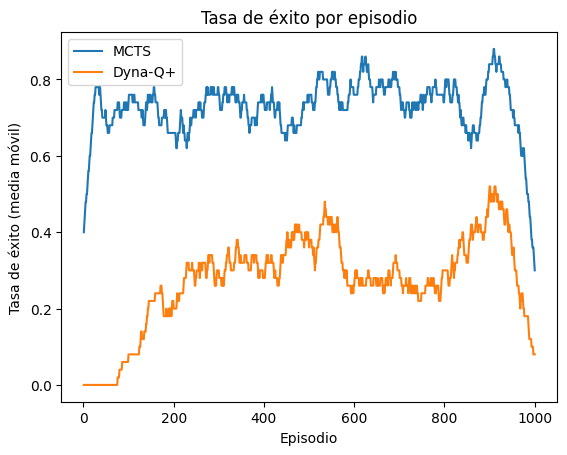

In [10]:
#graficas
episodes = np.arange(1, len(mcts_hist["rewards"]) + 1)

# 1) Tasa de éxito (rolling / moving average)
plt.figure()
plt.plot(episodes, moving_average(mcts_hist["successes"], w=50), label="MCTS")
plt.plot(episodes, moving_average(dyna_hist["successes"], w=50), label="Dyna-Q+")
plt.xlabel("Episodio")
plt.ylabel("Tasa de éxito (media móvil)")
plt.title("Tasa de éxito por episodio")
plt.legend()
plt.show()

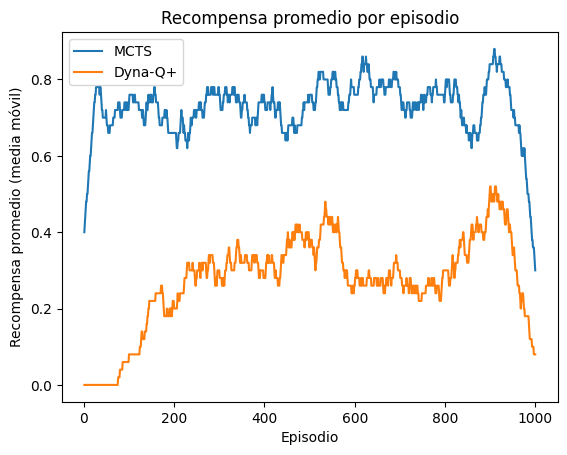

In [11]:
# 2) Recompensa promedio por episodio (moving average)
plt.figure()
plt.plot(episodes, moving_average(mcts_hist["rewards"], w=50), label="MCTS")
plt.plot(episodes, moving_average(dyna_hist["rewards"], w=50), label="Dyna-Q+")
plt.xlabel("Episodio")
plt.ylabel("Recompensa promedio (media móvil)")
plt.title("Recompensa promedio por episodio")
plt.legend()
plt.show()

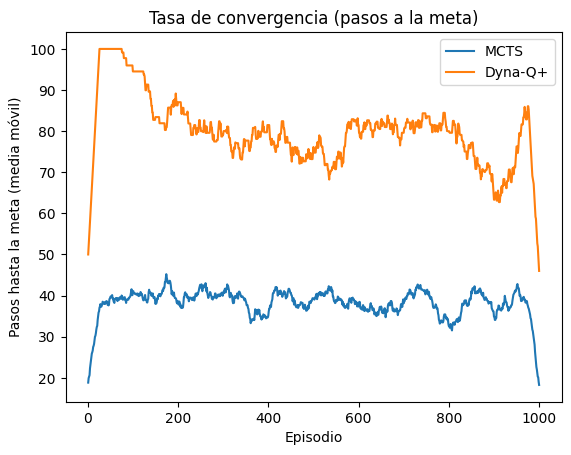

In [12]:
# 3) Pasos hasta la meta (menor es mejor; trazamos solo éxitos con media móvil aproximada)
plt.figure()
mcts_steps = np.where(mcts_hist["successes"]==1, mcts_hist["steps"], np.nan)
dyna_steps = np.where(dyna_hist["successes"]==1, dyna_hist["steps"], np.nan)
plt.plot(episodes, moving_average(np.nan_to_num(mcts_steps, nan=np.nanmedian(mcts_hist["steps"])), w=50), label="MCTS")
plt.plot(episodes, moving_average(np.nan_to_num(dyna_steps, nan=np.nanmedian(dyna_hist["steps"])), w=50), label="Dyna-Q+")
plt.xlabel("Episodio")
plt.ylabel("Pasos hasta la meta (media móvil)")
plt.title("Tasa de convergencia (pasos a la meta)")
plt.legend()
plt.show()

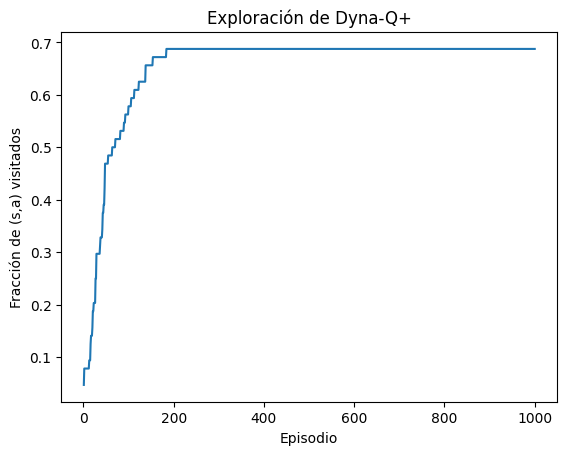

In [13]:
# 4) Exploración vs Explotación: pares (s,a) visitados / total (solo Dyna-Q+)
plt.figure()
plt.plot(episodes, dyna_hist["visited_frac"])
plt.xlabel("Episodio")
plt.ylabel("Fracción de (s,a) visitados")
plt.title("Exploración de Dyna-Q+")
plt.show()


## Análisis
### a. Compare los resultados de MCTS y Dyna-Q+.
- Los resultados muestran que MCTS supera significativamente a Dyna-Q+ en el entorno FrozenLake. MCTS alcanzó una tasa de éxito promedio de 73.6% y resolvió los episodios exitosos en aproximadamente 37 pasos promedio. Por otro lado, Dyna-Q+. obtuvo una tasa de éxito de 27.4% con un promedio de 81 pasos, pero en los casos de acierto usó menos pasos que MCTS.

### b. Analice las fortalezas y debilidades de cada enfoque en el contexto de FrozenLake-v1.
- MCTS:
    - **Fortalezas:** Es bastante robusto y eficiente con espacios pequeños como en este caso y reduce errores de exploración ciega.
    - **Debilidades:** es computacionalmente costoso y requiere muchas simulaciones por decisión, su rendimiento depende del número de simulaciones y de la profundidad.
- Dyna-Q+:
    - **Fortalezas:** Es computacionalmente más eficiente y acelera el aprendizaje en ambientes estocásticos más grandes.
    - **Debilidades:** su éxito depende de una buena configuración y del parámetro de bonificación. Con los parámetros que se le colocaron en esta práctica no logró aprovechar bien la expliración y quedó con políticas subóptimas.

### c. Considere el impacto de la naturaleza estocástica del entorno en el rendimiento de ambos algoritmos.
- MCTS es más robusto a la estocasticidad en este experimento, mientras que Dyna-Q+ necesitaría un ajuste más fino de hiperparámetros o más episodios para compensar la variabilidad del entorno.

## Preguntas
1. Estrategias de exploración:
    a. ¿Cómo influye la bonificación de exploración en Dyna-Q+ en la política en comparación con el equilibrio de exploración-explotación en MCTS? ¿Qué enfoque conduce a una convergencia más rápida en el entorno FrozenLake-v1?
    - R
2. Rendimiento del algoritmo:
    a. ¿Qué algoritmo, MCTS o Dyna-Q+, tuvo un mejor rendimiento en términos de tasa de éxito y recompensa promedio en el entorno FrozenLake-v1? Analice por qué uno podría superar al otro dada la naturaleza estocástica del entorno.
    - R
    
3. Impacto de las transiciones estocásticas:
    a. ¿Cómo afectan las transiciones probabilísticas en FrozenLake-v1 al proceso de planificación en MCTS en comparación con Dyna-Q+? ¿Qué algoritmo es más robusto a la aleatoriedad introducida por el entorno?
    - R
4. Sensibilidad de los parámetros:
    a. En la implementación de Dyna-Q+, ¿cómo afecta el cambio de la cantidad de pasos de planificación 𝑛 y la bonificación de exploración a la curva de aprendizaje y al rendimiento final? ¿Se necesitarían diferentes configuraciones para una versión determinista del entorno?
    - R